## Import Libraries

In [2]:
import sqlite3
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx
import plotly.express as px
import seaborn as sns

## Connect to the SQLite database

In [3]:
# Connect to the SQLite database
db_path = r'C:\Users\calua\OneDrive - Vodafone Group\Desktop\3Signet\Abc Project\ABC_pharm_db.db'
conn = sqlite3.connect(db_path)

# List all tables in the database
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in the database:", tables)

# Load the relevant data (adjust table names and queries based on database schema)
sales_data = pd.read_sql("SELECT * FROM FactSales;", conn)
locations = pd.read_sql("SELECT * FROM dimcustomer;", conn)

conn.close()

Tables in the database:                          name
0                       Index
1                     DimDate
2  product_lifecycle_analysis
3              DimDistributor
4                 DimCustomer
5                  DimProduct
6                 DimSalesRep
7                   FactSales
8             sqlite_sequence


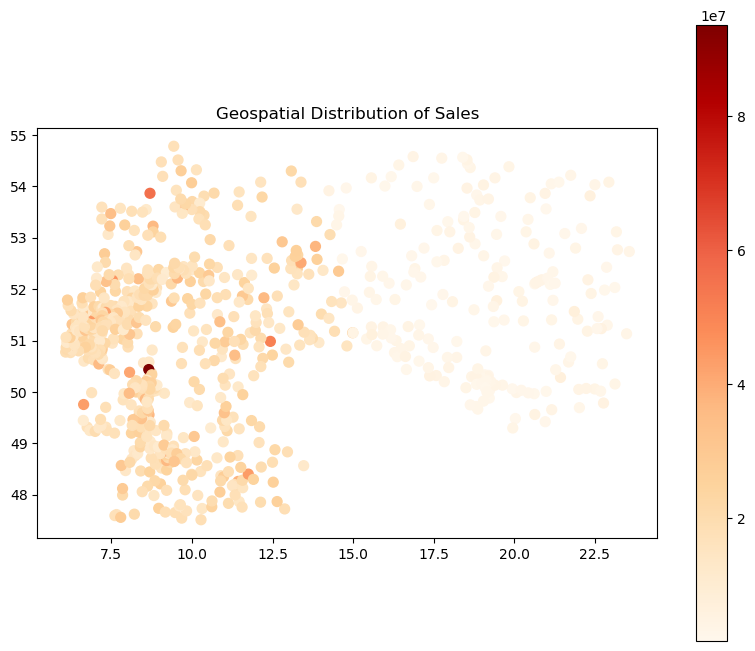

In [4]:
# Merge sales and location data
merged_data = pd.merge(sales_data, locations, on="CustomerID")

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(merged_data["Longitude"], merged_data["Latitude"])]
geo_df = gpd.GeoDataFrame(merged_data, geometry=geometry)

# Aggregate sales data by location
geo_sales = geo_df.groupby("geometry", as_index=False).agg({"Sales": "sum", "Quantity": "sum"})

# Set CRS (Coordinate Reference System)
geo_sales = gpd.GeoDataFrame(geo_sales, geometry="geometry")
geo_sales.set_crs(epsg=4326, inplace=True)  # WGS84 Latitude/Longitude

# Plot sales distribution
fig, ax = plt.subplots(figsize=(10, 8))
geo_sales.plot(column="Sales", cmap="OrRd", legend=True, ax=ax, markersize=50)
ax.set_title("Geospatial Distribution of Sales")
plt.show()

## Geospatial Sales Distribution

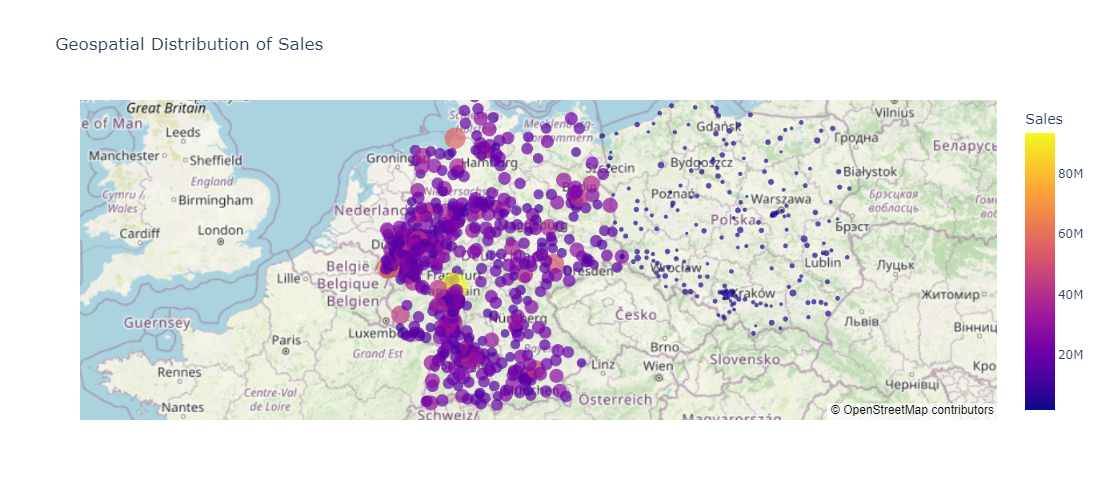

In [16]:
# Merge sales and location data
merged_data = pd.merge(sales_data, locations, on="CustomerID")

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(merged_data["Longitude"], merged_data["Latitude"])]
geo_df = gpd.GeoDataFrame(merged_data, geometry=geometry)

# Aggregate sales data by location
geo_sales = geo_df.groupby("geometry", as_index=False).agg({"Sales": "sum", "Quantity": "sum"})

# Set CRS (Coordinate Reference System)
geo_sales = gpd.GeoDataFrame(geo_sales, geometry="geometry")
geo_sales.set_crs(epsg=4326, inplace=True)  # WGS84 Latitude/Longitude

# Convert geo_sales back to a DataFrame suitable for Plotly
geo_sales_plotly = geo_sales.copy()
geo_sales_plotly["Latitude"] = geo_sales_plotly.geometry.y
geo_sales_plotly["Longitude"] = geo_sales_plotly.geometry.x

# Create a Plotly scatter mapbox with adjusted settings for a full map view
fig = px.scatter_mapbox(
    geo_sales_plotly,
    lat="Latitude",
    lon="Longitude",
    color="Sales",  # Color based on Sales values
    size="Sales",  # Use Sales for the marker size
    hover_name="Sales",  # Hover to show sales values
    hover_data={"Quantity": True, "Latitude": False, "Longitude": False},
    mapbox_style="open-street-map",  # Use OpenStreetMap as the basemap
    zoom=3,  # Zoom out for a larger view of the map
    center={"lat": geo_sales_plotly["Latitude"].mean(), "lon": geo_sales_plotly["Longitude"].mean()},
    title="Geospatial Distribution of Sales"
)

# Adjust the size of the figure for better visualization
fig.update_layout(
    height=500,  # Increase height for a larger map view
    width=1000   # Increase width for a larger map view
)

# Display the interactive map
fig.show()

## Sales performance across different channels

Channel Performance Metrics:
 Channel  Total_Sales  Total_Quantity    Avg_Sales  Transaction_Count
Hospital 5.580676e+09    1.366025e+07 44965.196506             124111
Pharmacy 6.218312e+09    1.501853e+07 47843.843155             129971


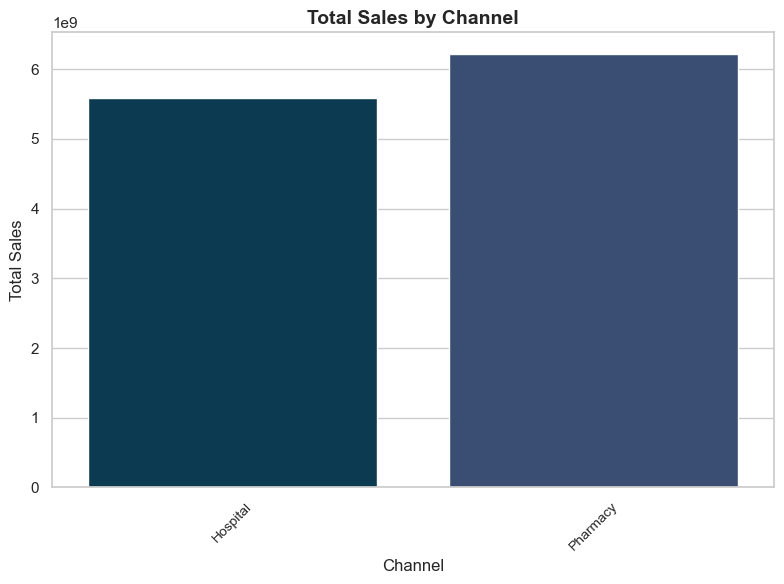

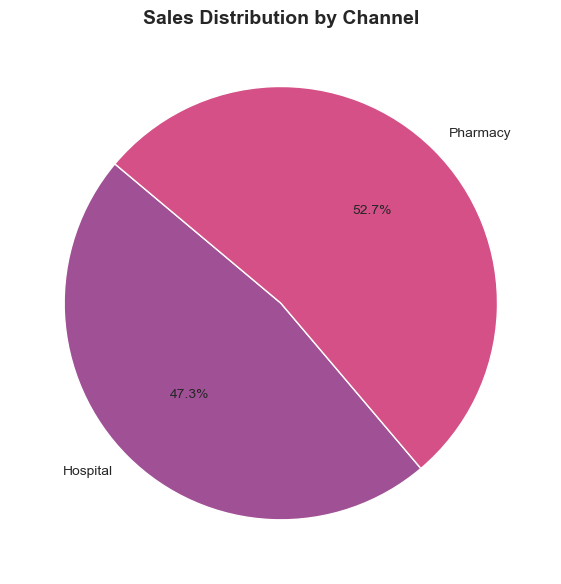

In [17]:
# Define corporate colors
corporate_palette = ["#003f5c", "#2f4b7c", "#665191"]  # Replace with your corporate colors
corporate_pie_colors = ["#a05195", "#d45087", "#f95d6a"]  # For the pie chart

# Group by Channel to compute sales performance metrics
channel_performance = merged_data.groupby("Channel", as_index=False).agg(
    Total_Sales=("Sales", "sum"),
    Total_Quantity=("Quantity", "sum"),
    Avg_Sales=("Sales", "mean"),
    Transaction_Count=("Sales", "count")
)

# Display the channel performance data
print("Channel Performance Metrics:")
print(channel_performance.to_string(index=False))

# Bar plot for total sales by channel with corporate colors
plt.figure(figsize=(8, 6))
sns.barplot(
    data=channel_performance, 
    x="Channel", 
    y="Total_Sales", 
    palette=corporate_palette
)
plt.title("Total Sales by Channel", fontsize=14, fontweight="bold")
plt.ylabel("Total Sales", fontsize=12)
plt.xlabel("Channel", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

# Pie chart for sales distribution by channel with corporate colors
plt.figure(figsize=(8, 6))
plt.pie(
    channel_performance["Total_Sales"],
    labels=channel_performance["Channel"],
    autopct='%1.1f%%',
    startangle=140,
    colors=corporate_pie_colors,  # Apply corporate colors
    textprops={'fontsize': 10}
)
plt.title("Sales Distribution by Channel", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


## Sub channel Sales Distribution

Sub Channel Performance Metrics:
Sub_Channel  Total_Sales  Total_Quantity    Avg_Sales  Transaction_Count
 Government 3.058240e+09    7.521996e+06 46615.962929              65605
Institution 2.875215e+09    6.956170e+06 46660.422562              61620
    Private 2.522435e+09    6.138254e+06 43114.129415              58506
     Retail 3.343097e+09    8.062358e+06 48910.724062              68351


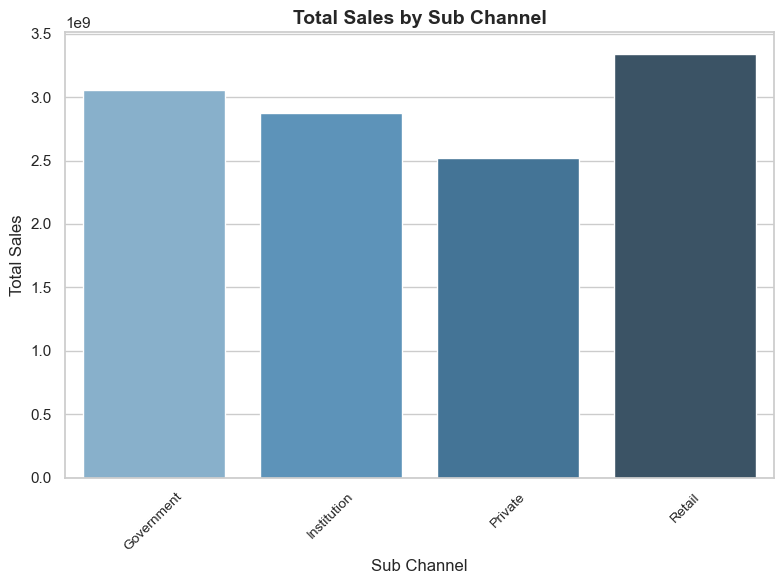

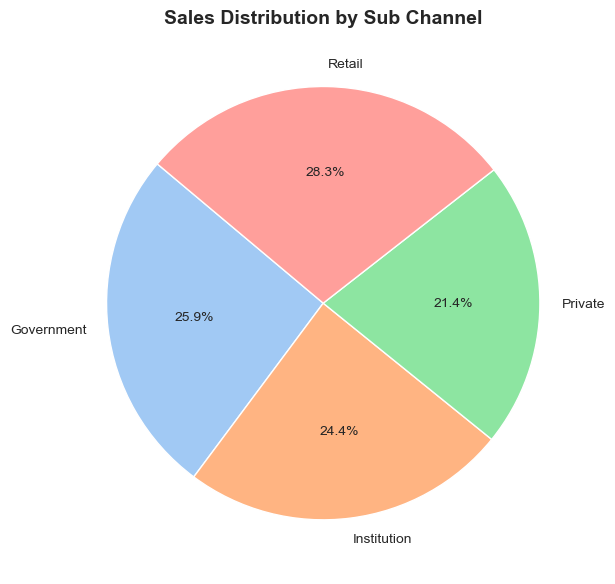

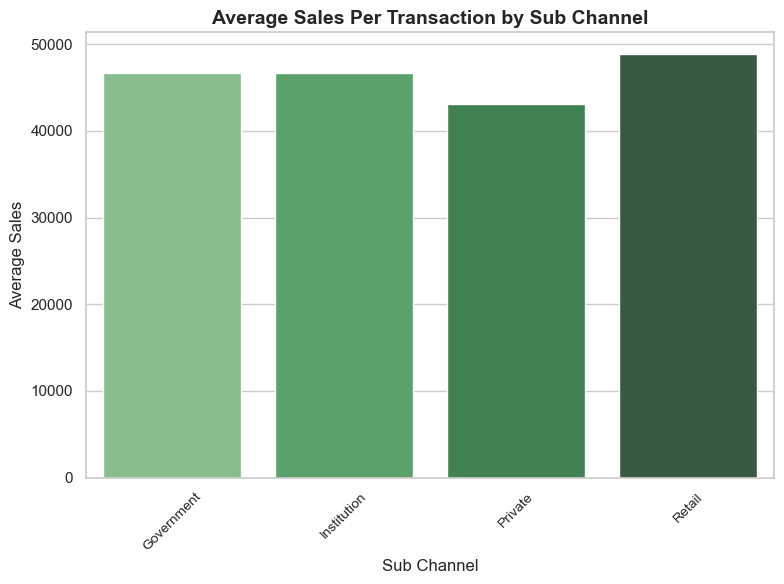

In [20]:
# Set theme for consistent and professional appearance
sns.set_theme(style="whitegrid")

# Group by Sub_Channel to compute sales performance metrics
channel_performance = merged_data.groupby("Sub_Channel", as_index=False).agg(
    Total_Sales=("Sales", "sum"),
    Total_Quantity=("Quantity", "sum"),
    Avg_Sales=("Sales", "mean"),
    Transaction_Count=("Sales", "count")
)

# Display the data in the console for verification
print("Sub Channel Performance Metrics:")
print(channel_performance.to_string(index=False))

# Plot 1: Bar plot for total sales by sub-channel
plt.figure(figsize=(8, 6))
sns.barplot(data=channel_performance, x="Sub_Channel", y="Total_Sales", palette="Blues_d")
plt.title("Total Sales by Sub Channel", fontsize=14, fontweight="bold")
plt.ylabel("Total Sales", fontsize=12)
plt.xlabel("Sub Channel", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

# Plot 2: Pie chart for sales distribution by sub-channel
plt.figure(figsize=(8, 6))
plt.pie(
    channel_performance["Total_Sales"],
    labels=channel_performance["Sub_Channel"],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("pastel"),
    textprops={'fontsize': 10}
)
plt.title("Sales Distribution by Sub Channel", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Plot 3: Bar plot for average sales per transaction by sub-channel
plt.figure(figsize=(8, 6))
sns.barplot(data=channel_performance, x="Sub_Channel", y="Avg_Sales", palette="Greens_d")
plt.title("Average Sales Per Transaction by Sub Channel", fontsize=14, fontweight="bold")
plt.ylabel("Average Sales", fontsize=12)
plt.xlabel("Sub Channel", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

## Impact of external factors